In [24]:
import numpy as np
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='paper',
    font_scale=8/8.8,
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [25]:
df = pd.read_csv('/projects/rlmolecule/pstjohn/tempo/small_mols.csv')
df.num_atoms.value_counts()

11    100
12    100
10      6
9       2
Name: num_atoms, dtype: int64

In [26]:
redox_data = pd.read_csv('/projects/rlmolecule/pstjohn/spin_gnn/redox_data.csv.gz')
data = pd.read_csv('/projects/rlmolecule/pstjohn/fingerprints/fp_mols_dft_and_ml.csv')

data['stability_ml'] = (1 - data['max_spin_ml']) * 50 + data['spin_buried_vol_ml']
data['stability_dft']  = (1 - data['max_spin_dft'])  * 50 + data['spin_buried_vol_dft']

data.head()

,smiles,ionization_energy_dft,electron_affinity_dft,max_spin_dft,spin_buried_vol_dft,ionization_energy_ml,electron_affinity_ml,max_spin_ml,spin_buried_vol_ml,stability_ml,stability_dft
0,C/C(=C/CS)c1scc(N)c1[O],1.084133,0.019890,0.281189,60.340356,1.021222,-0.172333,0.208897,60.177160,99.732325,96.280894
1,C/C=C(/C)C1=C(C)C(C)=C[CH]1,NaN,NaN,NaN,NaN,0.882303,-0.347784,0.302815,60.830734,95.689960,NaN
2,C/C=C(/C)C1=C(SC)[CH]C=C1,0.827752,-0.257770,0.329883,58.971385,0.919138,-0.214054,0.274094,61.927734,98.223051,92.477258
3,C/C=C(/C)C1=C[CH]C=C1/C=C/C,0.935888,-0.212872,0.291086,56.142447,0.828648,-0.330957,0.198025,60.565964,100.664696,91.588158
4,C/C=C(/C)[C]1C(C)=CC=C1C,1.141248,-0.385470,0.413889,51.789678,0.811673,-0.416348,0.272252,64.693665,101.081058,81.095231


In [27]:
redf_baseline = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/20210118_bde_baseline_spin_burvol.csv.gz')

def stability_score(x): 
    idxmax = x['fractional_spin'].idxmax()
    spin = x['fractional_spin'].max()
    bur_vol = x.loc[idxmax]['buried_vol']
    return bur_vol + 50 * (1 - spin)

bde_db_stability_scores = redf_baseline.groupby('smiles').apply(stability_score)

In [28]:
redf_baseline.atom_index.max()

9

In [29]:
bde_db_stability_scores[bde_db_stability_scores > 90].shape

(39,)

In [30]:
db_pass = redox_data[redox_data.smiles.isin(bde_db_stability_scores[bde_db_stability_scores > 90].index)].copy()
db_pass['V_diff'] = db_pass['ionization energy'] - db_pass['electron affinity']
db_pass['pass_redox'] = ((db_pass['electron affinity'] > -.5) &
                    (db_pass['ionization energy'] < 1.2) &
                    (db_pass['V_diff'] > 1))

In [31]:
db_pass['pass_redox'].sum()

0

In [32]:
import datashader as ds
from datashader.mpl_ext import dsshow
import datashader.transfer_functions as tf 

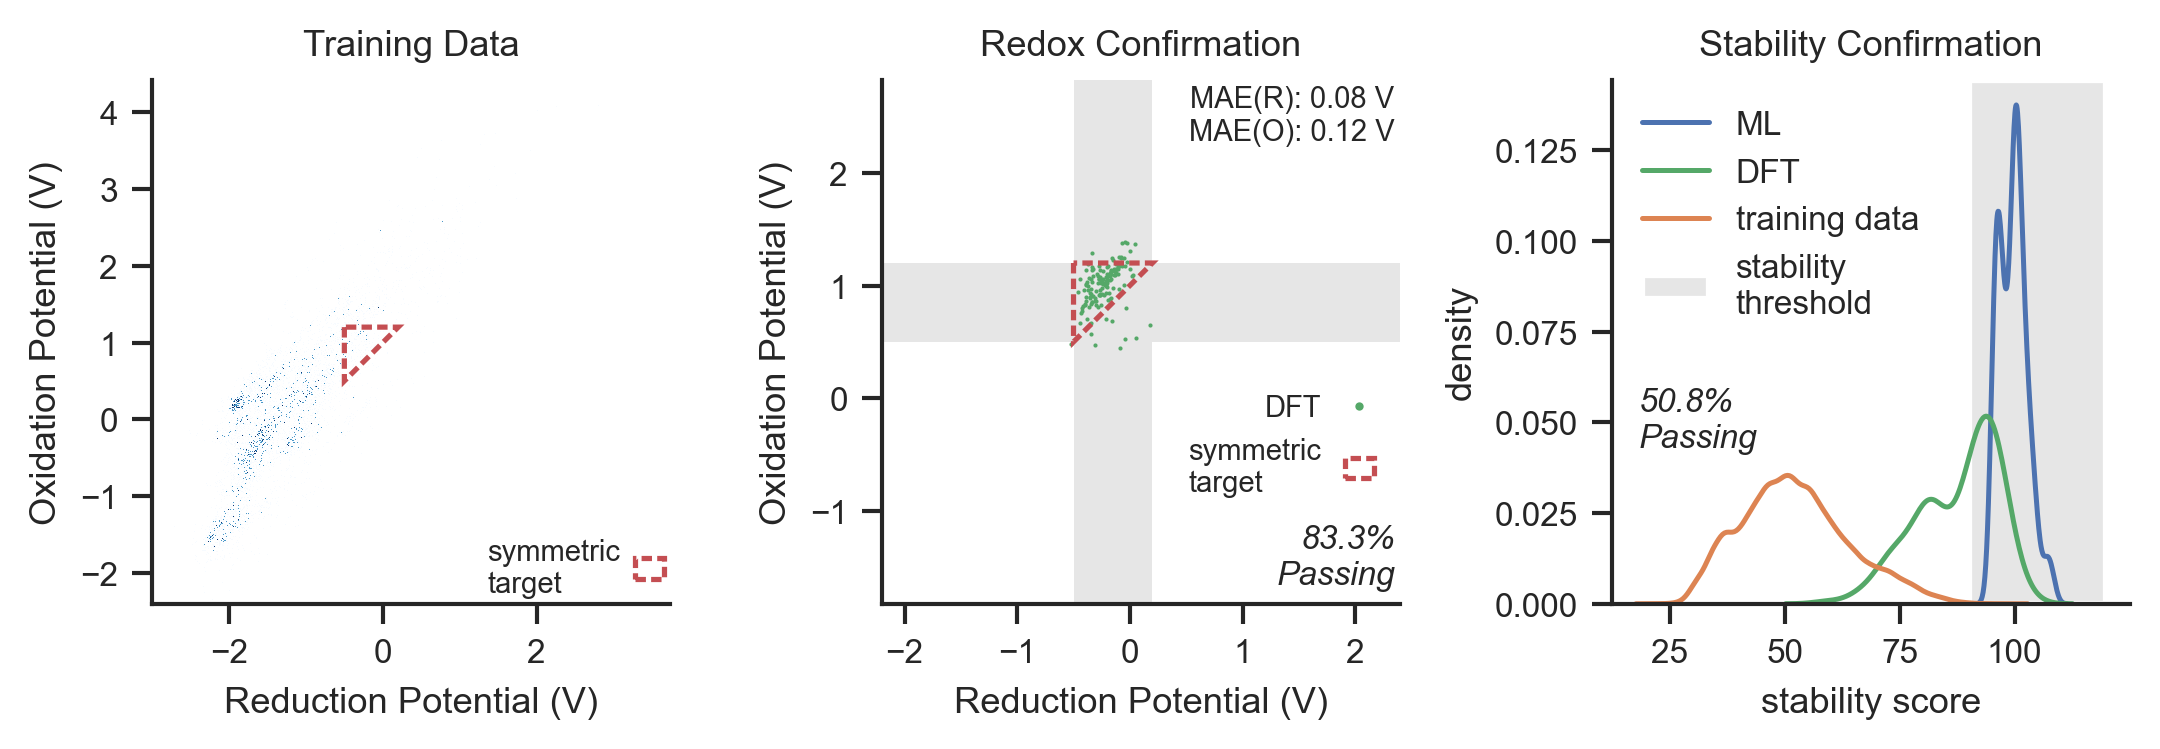

In [48]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(7,2.3), dpi=300)

## --------------------- ML predictions ---------------------
ax1 = fig.add_subplot(131, aspect='equal', adjustable='datalim')

# ax1.plot(data['electron_affinity_ml'], data['ionization_energy_ml'], '.', ms=.5, rasterized=True, color='orange', zorder=3, label='ML')

# artist = dsshow(redox_data, ds.Point('electron affinity', 'ionization energy'), ax=ax1, shade_hook=tf.dynspread,
#                 cmap='Blues', zorder=0, norm='eq_hist')  # scale is due to wierd dpi issues

artist = dsshow(redox_data, ds.Point('electron affinity', 'ionization energy'), ax=ax1, shade_hook=tf.dynspread,
                cmap='Blues', zorder=0, norm='eq_hist', width_scale=3.0, height_scale=3.0)  # scale is due to wierd dpi issues

# ax1.plot(redox_data['electron affinity'], redox_data['ionization energy'], '.', ms=.1,
#          rasterized=True, color=sns.color_palette()[1], zorder=1, label='training data')

# ax1.set_xlim([-3, 3.2])
# ax1.set_ylim([-2, 3])

# ax1.axvspan(-.5, .2, facecolor='.8', edgecolor='none', zorder=0, label='desired range')
# ax1.axhspan(.5, 1.2, facecolor='.8', edgecolor='none', zorder=0)

ax1.set_xlabel('Reduction Potential (V)')
ax1.set_ylabel('Oxidation Potential (V)')

ax1.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none',
                      zorder=5, edgecolor='r', lw=1.25, ls=(0, (2, 1)), label='symmetric\ntarget'))

ax1.legend(loc='lower right', markerfirst=False, markerscale=10, fontsize=7, borderpad=0,
           borderaxespad=0.2, handlelength=1, handletextpad=.5)


ax2 = fig.add_subplot(132, aspect='equal', adjustable='datalim')


## --------------------- DFT values ---------------------
ax2.plot(data['electron_affinity_dft'], data['ionization_energy_dft'], '.', ms=2., color='g', rasterized=True, zorder=3, label='DFT', markeredgewidth=0)

ax2.axvspan(-.5, .2, facecolor='.9', edgecolor='none', zorder=0)
ax2.axhspan(.5, 1.2, facecolor='.9', edgecolor='none', zorder=0)



ax2.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none',
                      zorder=5, edgecolor='r', lw=1.25, ls=(0, (2, 1)), label='symmetric\ntarget'))


ax2.set_xlim([-3, 3.2])
ax2.set_ylim([-2, 3])


ax2.set_xlabel('Reduction Potential (V)')
ax2.set_ylabel('Oxidation Potential (V)')


# ax2.yaxis.set_tick_params(which='both', labelleft=False, labelright=False)
# ax2.yaxis.offsetText.set_visible(False)


data['V_diff'] = data['ionization_energy_dft'] - data['electron_affinity_dft']
data['pass_redox'] = ((data['electron_affinity_dft'] > -.5) &
                    (data['ionization_energy_dft'] < 1.2) &
                    (data['V_diff'] > 1))

df_nona = data.dropna(subset=['ionization_energy_dft', 'electron_affinity_dft'])


df_pass = data[data.pass_redox]

ax2.text(.99, .025, f'{df_pass.shape[0] / df_nona.shape[0]:.1%}\nPassing', ha='right', va='bottom', transform=ax2.transAxes, fontsize='8', style='italic')

ax2.text(.99, .99, 
         f"MAE(R): {(data['electron_affinity_dft'] - data['electron_affinity_ml']).abs().mean():.2f} V\n"
         f"MAE(O): {(data['ionization_energy_dft'] - data['ionization_energy_ml']).abs().mean():.2f} V",
         ha='right', va='top', fontsize='7', transform=ax2.transAxes, )
# ax2.text(.99, .99, f", ha='right', va='top', fontsize='7', transform=ax2.transAxes, )

ax2.legend(loc='upper right', handlelength=1, markerscale=2, fontsize=7, bbox_to_anchor=(1., .45),  markerfirst=False)

## --------------------- stability scores ---------------------

ax3 = fig.add_subplot(133)
sns.kdeplot(data['stability_ml'], color='b', label='ML')
sns.kdeplot(data['stability_dft'], color='g', label='DFT')
sns.kdeplot(bde_db_stability_scores, color=sns.color_palette()[1], label='training data')

# ax3.axvline(100, ls='--', color='r', lw=1.5)
ax3.axvspan(90, 120, facecolor='.9', lw=1.5, label='stability\nthreshold')

ax3.legend(loc='upper left')

stability = data['stability_dft'].dropna()

ax3.text(.05, .35, f"{(stability > 90).mean():.1%}\nPassing",
         ha='left', va='center', transform=ax3.transAxes, fontsize='8', style='italic')

ax3.set_xticks([25, 50, 75, 100,])

ax3.set_ylabel('density')
ax3.set_xlabel('stability score')

ax1.set_title('Training Data')
ax2.set_title('Redox Confirmation')
ax3.set_title('Stability Confirmation')

sns.despine()
plt.tight_layout(pad=0., w_pad=1.08)
plt.savefig('figs/fig4_fp_dft_confirmation_alternate.svg')

In [52]:
def stability_score_components(x): 
    idxmax = x['fractional_spin'].idxmax()
    spin = x['fractional_spin'].max()
    bur_vol = x.loc[idxmax]['buried_vol']
    return pd.Series({'bur_vol': bur_vol, 'max_spin': spin})

redf_stability_components = redf_baseline.groupby('smiles').apply(stability_score_components)

In [60]:
redf_stability_components.max_spin *= 100

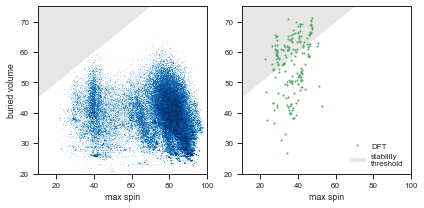

In [112]:
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(121)
artist = dsshow(redf_stability_components, ds.Point('max_spin', 'bur_vol'), shade_hook=tf.dynspread, aspect='auto', ax=ax, y_range=(20, 75), x_range=(10, 100),
                cmap='Blues', zorder=0, norm='eq_hist')  # scale is due to wierd dpi issues

ax.fill_between([10, 100], [90, 90], [45, 90], facecolor='.9')

ax2 = fig.add_subplot(122)
ax2.plot(data.max_spin_dft * 100, data.spin_buried_vol_dft, '.', ms=4, markeredgewidth=0, color='g', label='DFT')
ax2.fill_between([10, 100], [90, 90], [45, 90], facecolor='.9', label='stability\nthreshold')
ax2.set_xlim([10, 100])
ax2.set_ylim([20, 75])
ax2.legend(loc='lower right')

ax.set_xlabel('max spin')
ax2.set_xlabel('max spin')
ax.set_ylabel('buried volume')
plt.tight_layout()

plt.savefig('figs/stability_training.png', dpi=150)

# ax.plot(data.max_spin_dft * 100, data.spin_buried_vol_dft, '.', ms=4, markeredgewidth=0,)

(20.0, 90.0)

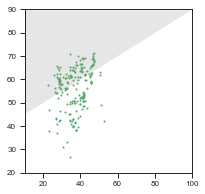

In [102]:
fig = plt.figure(figsize=(3,3))


In [78]:
data

,smiles,ionization_energy_dft,electron_affinity_dft,max_spin_dft,spin_buried_vol_dft,ionization_energy_ml,electron_affinity_ml,max_spin_ml,spin_buried_vol_ml,stability_ml,stability_dft,V_diff,pass_redox
0,C/C(=C/CS)c1scc(N)c1[O],1.084133,0.019890,0.281189,60.340356,1.021222,-0.172333,0.208897,60.177160,99.732325,96.280894,1.064243,True
1,C/C=C(/C)C1=C(C)C(C)=C[CH]1,NaN,NaN,NaN,NaN,0.882303,-0.347784,0.302815,60.830734,95.689960,NaN,NaN,False
2,C/C=C(/C)C1=C(SC)[CH]C=C1,0.827752,-0.257770,0.329883,58.971385,0.919138,-0.214054,0.274094,61.927734,98.223051,92.477258,1.085522,True
3,C/C=C(/C)C1=C[CH]C=C1/C=C/C,0.935888,-0.212872,0.291086,56.142447,0.828648,-0.330957,0.198025,60.565964,100.664696,91.588158,1.148760,True
4,C/C=C(/C)[C]1C(C)=CC=C1C,1.141248,-0.385470,0.413889,51.789678,0.811673,-0.416348,0.272252,64.693665,101.081058,81.095231,1.526718,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,NCCC1=C2C=CC=C2S[CH]1,1.040813,-0.198613,0.374962,38.283357,0.984373,-0.227808,0.204206,55.804420,95.594122,69.535239,1.239426,True
204,N[C@H]1CCCc2cc([O])sc21,1.143670,-0.109090,0.387803,59.889197,0.936372,-0.224195,0.263990,59.978077,96.778563,90.499065,1.252760,True
205,OCCC1=C2C=CC=C2S[CH]1,1.087017,-0.175185,0.376523,38.269865,0.996142,-0.187819,0.209594,56.497917,96.018198,69.443737,1.262202,True
206,[O]c1cc2c(s1)C(=S)CCN2,NaN,0.485658,0.329606,32.974961,1.077258,-0.044238,0.250956,58.069195,95.521371,66.494651,NaN,False


In [75]:
90 - (1 - .1)*50

45.0

In [51]:
redf_baseline

,smiles,atom_type,atom_index,spin,buried_vol,fractional_spin
0,[CH2]C1=COCC1,C,0,0.586646,30.291542,0.405000
1,[CH2]C1=COCC1,C,1,-0.180922,41.879991,0.124902
2,[CH2]C1=COCC1,C,2,0.570409,38.252099,0.393790
3,[CH2]C1=COCC1,O,3,0.096694,33.700549,0.066754
4,[CH2]C1=COCC1,C,4,-0.002564,34.074425,0.001770
...,...,...,...,...,...,...
740620,[CH2]N1CCC(=O)N1C,C,3,0.022799,39.900312,0.021027
740621,[CH2]N1CCC(=O)N1C,C,4,-0.000727,45.453995,0.000670
740622,[CH2]N1CCC(=O)N1C,O,5,0.006317,31.509441,0.005826
740623,[CH2]N1CCC(=O)N1C,N,6,0.005283,51.115920,0.004872


In [ ]:
artist.get_legend_elements()

In [ ]:
(data['pass_redox'].astype(bool) & (data['stability_dft'] > 85)).sum() / data.dropna().shape[0]

In [ ]:
(~data['V_diff'].isna()).sum()

In [ ]:
data['pass_redox'].sum()

In [ ]:
(data['pass_redox'].astype(bool) & (data['stability_dft'] > 93.9)).sum()

In [ ]:
(df_nona['stability_dft'] > 90).sum()

In [ ]:
# with open('figs/fp_mols.svg', 'w') as f:
#    f.write(img.data)

In [ ]:
# joined.to_csv('figs/fp_mols.csv')

## Plot DFT vs. ML spin and buried volume

In [ ]:
import rdkit
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

stability_model = tf.keras.models.load_model('/projects/rlmolecule/pstjohn/models/20210214_radical_stability_new_data/', compile=False)
from rlmolecule.molecule.policy.preprocessor import load_preprocessor

preprocessor = load_preprocessor()

def pred_stability(smiles):
    
    mol = rdkit.Chem.MolFromSmiles(smiles)
    
    spins, bvs = stability_model(
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in preprocessor.construct_feature_matrices(mol).items()})

    return pd.DataFrame({
        'fractional_spin': spins.numpy().flatten(),
        'buried_vol': bvs.numpy().flatten(),
        'atom_type': np.array([atom.GetSymbol() for atom in mol.GetAtoms()]),
        'atom_index': np.arange(mol.GetNumAtoms()),
        'smiles': [smiles] * mol.GetNumAtoms()
    })

In [ ]:
dft_spins = pd.read_csv('/projects/rlmolecule/pstjohn/tempo/20210707_rl_dft_spin_bv_run_21.csv.gz', index_col=0)
dft_spins['fractional_spin'] = dft_spins.groupby('smiles').spin.apply(lambda x: x.abs() / x.abs().sum())

In [ ]:
ml_stability = data.smiles.apply(pred_stability)
ml_stability = pd.concat(ml_stability.tolist())

In [ ]:
merged_stability = ml_stability.merge(dft_spins, how='outer', on=['smiles', 'atom_index'], suffixes=['_ml', '_dft'])

In [ ]:
ml_valid_preds = pd.read_csv('/projects/rlmolecule/pstjohn/spin_gnn/20210215_spin_bv_validation_predictions.csv.gz')
ml_valid_preds.head()

In [ ]:
fig = plt.figure(figsize=(4,2.3), dpi=150)

ax1 = fig.add_subplot(121, aspect='equal', adjustable='box')

smiles_max = merged_stability.groupby('smiles').max()


ax1.plot(merged_stability.fractional_spin_ml, merged_stability.fractional_spin_dft, '.', ms=1, label='generated molecules', alpha=.75)
ax1.plot(smiles_max.fractional_spin_ml, smiles_max.fractional_spin_dft, '.', ms=1., label='max spin per molecule', color='g')
ax1.plot(ml_valid_preds.fractional_spin_ml, ml_valid_preds.fractional_spin_dft, '.', ms=1, alpha=.25, color='.6', zorder=0, label='ML validation predictions', rasterized=True)

# ax1.plot(merged_stability.fractional_spin_ml, merged_stability.fractional_spin_dft, '.', ms=1, label='individual atom spin', alpha=.75)
# ax1.plot(smiles_max.fractional_spin_ml, smiles_max.fractional_spin_dft, '.', ms=3, label='max spin per molecule')
ax1.plot([0, 1], [0, 1], '--', color='w', zorder=2)
# ax1.set_xticks(.1*np.arange(6))
# ax1.set_yticks(.1*np.arange(6))

ax1.legend(loc='lower left', bbox_to_anchor=(0, 1.), fontsize=7, borderpad=0,
           borderaxespad=0.2, handlelength=1, handletextpad=.5, markerscale=2)

ax1.set_ylim([-.01, 1.01])
ax1.set_xlim([-.01, 1.01])


ax2 = fig.add_subplot(122, aspect='equal', adjustable='box')

ax2.plot(merged_stability.buried_vol_ml, merged_stability.buried_vol_dft, '.', ms=1, label='generated molecules')
ax2.plot(ml_valid_preds.buried_vol_ml, ml_valid_preds.buried_vol_dft, '.', ms=1, alpha=.25, color='.6', zorder=0, label='ML validation predictions', rasterized=True)

ax2.plot([20, 80], [20, 80], '--', color='w', zorder=2)
ax2.set_ylim([20, 80])
ax2.set_xlim([20, 80])
ax2.set_yticks([20, 40, 60, 80])
ax2.set_xticks([20, 40, 60, 80])

ax2.legend(loc='lower left', bbox_to_anchor=(0, 1.), fontsize=7, borderpad=0,
           borderaxespad=0.2, handlelength=1, handletextpad=.5, markerscale=2)

sns.despine(offset=5, trim=True)

ax1.set_xlabel('Atom Fractional Spin (ML)')
ax1.set_ylabel('Atom Fractional Spin (DFT)')

ax2.set_xlabel('Atom Buried Volume (ML)')
ax2.set_ylabel('Atom Buried Volume (DFT)')

plt.tight_layout()
# plt.savefig('figs/spin_bv_prediction_for_new_mols.svg')

In [ ]:
merged_stability.fractional_spin_ml.max()

In [ ]:
fig = plt.figure(figsize=(2.3,2.3), dpi=150)
ax1 = fig.add_subplot(111, aspect='equal', adjustable='datalim')

ax1.plot(merged_stability.fractional_spin_ml, merged_stability.fractional_spin_dft, '.', ms=1, label='individual atom spin', alpha=.75)
ax1.plot(smiles_max.fractional_spin_ml, smiles_max.fractional_spin_dft, '.', ms=1., label='max spin per molecule', color='g')

ax1.plot(ml_valid_preds.fractional_spin_ml,
         ml_valid_preds.fractional_spin_dft, '.', ms=1, alpha=.5, color='.6', zorder=0)

In [ ]:
# results = (ml_valid_preds.groupby('smiles').fractional_spin_ml.max() < .35) & (ml_valid_preds.groupby('smiles').atom_index.max() >= 8)
# to_plot = results[results].index

# fig = plt.figure(figsize=(2.3,2.3), dpi=150)

# ax1 = fig.add_subplot(111, aspect='equal', adjustable='datalim')

# smiles_max = ml_valid_preds[ml_valid_preds.smiles.isin(to_plot)].groupby('smiles').max()

# ax1.plot(ml_valid_preds[ml_valid_preds.smiles.isin(to_plot)].fractional_spin_ml,
#          ml_valid_preds[ml_valid_preds.smiles.isin(to_plot)].fractional_spin_dft, '.', ms=1, alpha=.5)
# ax1.plot(smiles_max.fractional_spin_ml, smiles_max.fractional_spin_dft, '.', ms=3, label='max spin per molecule')

# ax1.plot([0, .5], [0, .5], '--', color='.7', zorder=2)
# ax1.set_xticks(.1*np.arange(6))
# ax1.set_yticks(.1*np.arange(6))

# ax1.set_ylim([-.01, .55])
# ax1.set_xlim([-.01, .55])

In [ ]:
passing = df_nona[df_nona['pass_redox'].astype(bool) & (df_nona['stability_dft'] > 93.9)]
# passing.to_csv('20210716_passing.csv', index=False)

In [ ]:
def process(x):
    mol = rdkit.Chem.MolFromSmiles(x)
    for atom in mol.GetAtoms():
        if atom.GetNumRadicalElectrons() == 1:
            radical_idx = atom.GetIdx()
            symbol = atom.GetSymbol()
            break            
    else:
        radical_idx = None
        symbol = None
        
    return pd.Series({'radical_idx': radical_idx,
                      'symbol': symbol,
                      'num_atoms': mol.GetNumAtoms()})

In [ ]:
joined = passing.join(passing.smiles.apply(process))
joined = joined.sort_values('stability_dft', ascending=False).reset_index(drop=True)

In [ ]:
max_spin_index = dft_spins.groupby('smiles').apply(lambda x: x.loc[x.fractional_spin.idxmax(), 'atom_index'])

In [ ]:
joined['max_spin_index'] = max_spin_index.reindex(joined.smiles).values

In [ ]:
from rdkit.Chem.Draw import MolsToGridImage, rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.legendFontSize = 14
IPythonConsole.drawOptions.addAtomIndices = False

img = IPythonConsole.ShowMols(joined.smiles.apply(rdkit.Chem.MolFromSmiles), molsPerRow=5,
                              subImgSize=(200, 200), useSVG=True, maxMols=100,
                              legends=[str(i) for i in joined.index],
                              highlightAtomLists=[[i] for i in joined.max_spin_index],
                              
                             )

In [ ]:
img

In [ ]:
synthesizability = pd.read_csv('/home/pstjohn/Research/20210716_askcos_synthesizability/fp_results2.csv', header=None)
synthesizability.columns = ['smiles', 'status', 'trees']

mol_smiles = pd.read_csv('/home/pstjohn/Research/20210716_askcos_synthesizability/molecule_smiles.csv', index_col=0)

synthesizability = synthesizability.merge(mol_smiles, on='smiles')

In [ ]:
synthesizability['status'].value_counts()

In [ ]:
joined[joined.smiles.isin(synthesizability[synthesizability['status'] == 'synthesizable'].radical_smiles)].iloc[:, :1]

In [ ]:
synthesizability[synthesizability['status'] == 'synthesizable'].radical_smiles

In [ ]:
pd.read_csv('/scratch/pstjohn/synthesizable_mols.csv')

In [ ]:
joined[joined.smiles.isin(synthesizability[synthesizability['status'] == 'synthesizable'].radical_smiles)]

### Get molecular structures for the action space diagram

In [ ]:
'CCC(C)(C)c1cc(O)c([O])s1'